In [ ]:
!nvidia-smi

Thu Jun  8 18:50:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 23.2 MB/s eta 0:00:00


In [ ]:
!wget -O Bone_Age_Training_Set.zip "https://s3.amazonaws.com/east1.public.rsna.org/AI/2017/Bone+Age+Training+Set.zip"


--2023-06-08 18:51:11--  https://s3.amazonaws.com/east1.public.rsna.org/AI/2017/Bone+Age+Training+Set.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.32.134, 52.217.137.48, 52.216.147.150, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.32.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9799344140 (9.1G) [application/zip]
Saving to: ‘Bone_Age_Training_Set.zip’

Bone_Age_Training_S 100%[===================>]   9.13G  8.35MB/s    in 12m 54s 

2023-06-08 19:04:06 (12.1 MB/s) - ‘Bone_Age_Training_Set.zip’ saved [9799344140/9799344140]



In [ ]:
import zipfile

zip_path = "Bone_Age_Training_Set.zip"
extract_path = "/content/extracted_files"  # Specify the path where you want to extract the files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/')

In [ ]:
import pandas as pd

In [ ]:
import densenet as Densenet

In [ ]:
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from torch import nn
import torch
import os
import torchvision.datasets as dset
import torchvision.transforms as transforms
import gpytorch
import math
import tqdm

In [ ]:
normalize = transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
aug_trans = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]
common_trans = [transforms.ToTensor(), normalize]
train_compose = transforms.Compose(aug_trans + common_trans)
test_compose = transforms.Compose(common_trans)

In [ ]:
# import os
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from PIL import Image


# class MyDataset(Dataset):
#     def __init__(self, image_list, label_list, transform=None):
#         self.image_list = image_list
#         self.label_list = label_list
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_list)

#     def __getitem__(self, idx):
#         image = self.image_list[idx]
#         label = self.label_list[idx]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label

# # Directory path where the images are stored
# image_dir = '/content/extracted_files/boneage-training-dataset'  # Replace with the path to your image directory


# # Path to the CSV file containing the labels
# csv_path = '/content/train.csv'  # Replace with the path to your CSV file

# # Load the CSV file into a pandas DataFrame
# df = pd.read_csv(csv_path)

# # Extract image file names and labels from the DataFrame
# image_files = df['id'].astype(str).tolist()  # Convert to string
# labels = df['boneage'].tolist()

# # Get the first 5000 data points
# image_files = image_files[:5000]
# labels = labels[:5000]

# # Split the dataset into train set and test set
# train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# # Create a list to store the train and test image data
# train_image_list = []
# test_image_list = []

# # Iterate over the train image file names and load the corresponding images
# for train_file in tqdm.tqdm(train_files, desc='Loading Train Images'):
#     train_image_path = os.path.join(image_dir, str(train_file) + '.png')  # Convert to string
#     train_image = Image.open(train_image_path)
#     train_image_list.append(train_image)

# # Iterate over the test image file names and load the corresponding images
# for test_file in tqdm.tqdm(test_files, desc='Loading Test Images'):
#     test_image_path = os.path.join(image_dir, str(test_file)+'.png')  # Convert to string
#     test_image = Image.open(test_image_path)
#     test_image_list.append(test_image)

# normalize = transforms.Normalize(mean=[0.5071], std=[0.2675])
# aug_trans = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]
# common_trans = [transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), 
#                 transforms.Lambda(lambda x: x.repeat(3, 1, 1)), normalize]
# train_compose = transforms.Compose(aug_trans + common_trans)
# test_compose = transforms.Compose(common_trans)


# # Create instances of the custom dataset for train set and test set
# train_dataset = MyDataset(train_image_list, train_labels, transform=train_compose)
# test_dataset = MyDataset(test_image_list, test_labels, transform=test_compose)

# # Define the batch size and create data loaders for train set and test set
# batch_size = 256
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import os
import pandas as pd
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, image_list, label_list, transform=None):
        self.image_list = image_list
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        label = self.label_list[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Directory path where the images are stored
image_dir = '/content/extracted_files/boneage-training-dataset'  # Replace with the path to your image directory

# Path to the CSV file containing the labels
csv_path = '/content/train.csv'  # Replace with the path to your CSV file

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Extract image file names and labels from the DataFrame
image_files = df['id'].astype(str).tolist()  # Convert to string
labels = df['boneage'].tolist()

# Get the first 5000 data points
# image_files = image_files[:5000]
# labels = labels[:5000]

# Split the dataset into train set and test set
train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Create a list to store the train and test image data
train_image_list = []
test_image_list = []

# Iterate over the train image file names and load the corresponding images
for train_file in tqdm(train_files, desc='Loading Train Images'):
    train_image_path = os.path.join(image_dir, str(train_file) + '.png')  # Convert to string
    train_image = cv2.imread(train_image_path)

    # Perform image processing steps
    image1 = cv2.bitwise_not(train_image)
    processed_image = image1 - train_image
    processed_image2 = cv2.resize(processed_image, (32, 32))
    processed_image_pil = Image.fromarray(processed_image2)

    train_image_list.append(processed_image_pil)

# Iterate over the test image file names and load the corresponding images
for test_file in tqdm(test_files, desc='Loading Test Images'):
    test_image_path = os.path.join(image_dir, str(test_file) + '.png')  # Convert to string
    test_image = cv2.imread(test_image_path)

    # Perform image processing steps
    image1 = cv2.bitwise_not(test_image)
    processed_image = image1 - test_image
    processed_image2 = cv2.resize(processed_image, (32, 32))
    processed_image_pil = Image.fromarray(processed_image2)

    test_image_list.append(processed_image_pil)

normalize = transforms.Normalize(mean=[0.5071], std=[0.2675])
aug_trans = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]
common_trans = [transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
                transforms.Lambda(lambda x: x.repeat(3, 1, 1)), normalize]
train_compose = transforms.Compose(aug_trans + common_trans)
test_compose = transforms.Compose(common_trans)

# Create instances of the custom dataset for train set and test set
train_dataset = MyDataset(train_image_list, train_labels, transform=train_compose)
test_dataset = MyDataset(test_image_list, test_labels, transform=test_compose)

# Define the batch size and create data loaders for train set and test set
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Loading Test Images: 100%|██████████| 2523/2523 [01:15<00:00, 33.21it/s]


In [ ]:
unique_labels = list(set(labels))
print(len(unique_labels))
print(max(unique_labels))

160
228


In [ ]:
print(len(train_loader.dataset))

# Assuming each batch has the same number of samples, you can get the batch size
batch_size = train_loader.batch_size
print("Batch size:", batch_size)


10088
Batch size: 256


In [ ]:
# dataset = "cifar10"


# if ('CI' in os.environ):  # this is for running the notebook in our testing framework
#     train_set = torch.utils.data.TensorDataset(torch.randn(8, 3, 32, 32), torch.rand(8).round().long())
#     test_set = torch.utils.data.TensorDataset(torch.randn(4, 3, 32, 32), torch.rand(4).round().long())
#     train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(test_set, batch_size=2, shuffle=False)
#     num_classes = 2
# elif dataset == 'cifar10':
#     train_set = dset.CIFAR10('data', train=True, transform=train_compose, download=True)
#     test_set = dset.CIFAR10('data', train=False, transform=test_compose)
#     train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)
#     num_classes = 10
# elif dataset == 'cifar100':
#     train_set = dset.CIFAR100('data', train=True, transform=train_compose, download=True)
#     test_set = dset.CIFAR100('data', train=False, transform=test_compose)
#     train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)
#     num_classes = 100
# else:
#     raise RuntimeError('dataset must be one of "cifar100" or "cifar10"')

# print(len(train_loader.dataset))

# # Assuming each batch has the same number of samples, you can get the batch size
# batch_size = train_loader.batch_size
# print("Batch size:", batch_size)


In [ ]:
!pip install densenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from densenet import DenseNet
num_classes = 229
class DenseNetFeatureExtractor(DenseNet):
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=self.avgpool_size).view(features.size(0), -1)
        return out

feature_extractor = DenseNetFeatureExtractor(block_config=(6, 6, 6), num_classes=num_classes)
num_features = feature_extractor.classifier.in_features

In [ ]:
class GaussianProcessLayer(gpytorch.models.ApproximateGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
        )
        
        # Our base variational strategy is a GridInterpolationVariationalStrategy,
        # which places variational inducing points on a Grid
        # We wrap it with a IndependentMultitaskVariationalStrategy so that our output is a vector-valued GP
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.GridInterpolationVariationalStrategy(
                self, grid_size=grid_size, grid_bounds=[grid_bounds],
                variational_distribution=variational_distribution,
            ), num_tasks=num_dim,
        )
        super().__init__(variational_strategy)
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [ ]:
class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim
                    
        # This module will scale the NN features so that they're nice values
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(self.grid_bounds[0], self.grid_bounds[1])

    def forward(self, x):
        features = self.feature_extractor(x)
        features = self.scale_to_bounds(features)
        # This next line makes it so that we learn a GP for each feature
        features = features.transpose(-1, -2).unsqueeze(-1)
        res = self.gp_layer(features)
        return res


# class DKLModel(gpytorch.Module):
#     def __init__(self, feature_extractor, num_dim, grid_bounds=(-10., 10.)):
#         super(DKLModel, self).__init__()
#         self.feature_extractor = feature_extractor
#         self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
#         self.grid_bounds = grid_bounds
#         self.num_dim = num_dim

#         # This module will scale the NN features so that they're nice values
#         self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(self.grid_bounds[0], self.grid_bounds[1])

#     def forward(self, x):
#         features = self.feature_extractor(x)
#         print("Features dimensions:", features.shape)  # Print the dimensions of the features
#         features = self.scale_to_bounds(features)
#         # This next line makes it so that we learn a GP for each feature
#         features = features.transpose(-1, -2).unsqueeze(-1)
#         res = self.gp_layer(features)
#         return res


model = DKLModel(feature_extractor, num_dim=num_features)
likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=model.num_dim, num_classes=num_classes)


# If you run this example without CUDA, I hope you like waiting!
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()


In [ ]:
import tqdm# import tqdm

In [ ]:
n_epochs = 1
lr = 0.1
optimizer = SGD([
    {'params': model.feature_extractor.parameters(), 'weight_decay': 1e-4},
    {'params': model.gp_layer.hyperparameters(), 'lr': lr * 0.01},
    {'params': model.gp_layer.variational_parameters()},
    {'params': likelihood.parameters()},
], lr=lr, momentum=0.9, nesterov=True, weight_decay=0)
scheduler = MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)
mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader.dataset))


def train(epoch):
    model.train()
    likelihood.train()

    minibatch_iter = tqdm.tqdm(train_loader, desc=f"(Epoch {epoch}) Minibatch")
    with gpytorch.settings.num_likelihood_samples(8):
        for data, target in minibatch_iter:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = -mll(output, target)
            loss.backward()
            optimizer.step()
            minibatch_iter.set_postfix(loss=loss.item())
        
# def test():
#     model.eval()
#     likelihood.eval()

#     correct = 0
#     with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
#         for data, target in test_loader:
#             if torch.cuda.is_available():
#                 data, target = data.cuda(), target.cuda()
#             output = likelihood(model(data))  # This gives us 16 samples from the predictive distribution
#             pred = output.probs.mean(0).argmax(-1)  # Taking the mean over all of the sample we've drawn
#             correct += pred.eq(target.view_as(pred)).cpu().sum()
#     print('Test set: Accuracy: {}/{} ({}%)'.format(
#         correct, len(test_loader.dataset), 100. * correct / float(len(test_loader.dataset))
#     ))

# def test():
#     model.eval()
#     likelihood.eval()

#     correct = 0
#     with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
#         for data, target in test_loader:
#             if torch.cuda.is_available():
#                 data, target = data.cuda(), target.cuda()
#             output = likelihood(model(data))  # This gives us 16 samples from the predictive distribution
#             pred = output.probs.mean(0).argmax(-1)  # Taking the mean over all of the sample we've drawn
#             is_within_range = torch.abs(pred - target) <= 15
#             # Check if the predicted class is within a range of +/- 10 from the target class
#             correct += is_within_range.cpu().sum()
            
#     print('Test set: Accuracy within +/- 10: {}/{} ({}%)'.format(
#         correct, len(test_loader.dataset), 100. * correct / float(len(test_loader.dataset))
#     ))
import torch
import torch.nn.functional as F
import numpy as np

import torch
import torch.nn.functional as F
import numpy as np

def test(k_quantile):
    model.eval()
    likelihood.eval()

    squared_errors = []
    correct = 0
    total = 0

    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = likelihood(model(data))  # This gives us 16 samples from the predictive distribution
            probabilities = output.probs.mean(0)  # Taking the mean over all of the samples
            pred = output.probs.mean(0).argmax(-1)  # Taking the mean over all of the sample we've drawn
            squared_error = F.mse_loss(pred.float(), target.float(), reduction='none')
            squared_errors.append(squared_error.cpu())

            # Calculate test accuracy
            is_within_range = torch.abs(pred - target) <= 10
            correct += is_within_range.cpu().sum()
            total += target.size(0)

    all_squared_errors = torch.cat(squared_errors)
    k_quantile_value = np.percentile(all_squared_errors.numpy(), k_quantile)
    rmse = np.sqrt(k_quantile_value)

    accuracy = 100. * correct / total

    print('RMSE ({}-quantile): {}'.format(k_quantile, rmse))
    print('Test accuracy within +/- 10: {}/{} ({}%)'.format(correct, total, accuracy))

def test(k_quantile):
  model.eval()
  likelihood.eval()
  correct = 0
  feature_embeddings = []  # List to store the feature embeddings
  labels = []  # List to store the corresponding labels
  total = 0
  with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = likelihood(model(data))  # This gives us 16 samples from the predictive distribution
        pred = output.probs.mean(0).argmax(-1)  # Taking the mean over all of the sample we've drawn

        # Extract the feature embeddings from the model
        features = model.feature_extractor(data)

        # Append the feature embeddings and labels to the lists
        feature_embeddings.append(features.cpu().numpy())
        labels.append(target.cpu().numpy())

        # Calculate test accuracy
        is_within_range = torch.abs(pred - target) <= 10
        correct += is_within_range.cpu().sum()
        total += target.size(0)

  # Concatenate the feature embeddings and labels
  feature_embeddings = np.concatenate(feature_embeddings, axis=0)
  labels = np.concatenate(labels, axis=0)

  # Call the function to visualize feature embeddings
  visualize_feature_embeddings(feature_embeddings, labels)

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
def visualize_feature_embeddings(feature_embeddings, labels):
  tsne = TSNE(n_components=2, random_state=42)
  embeddings_tsne = tsne.fit_transform(feature_embeddings)
  plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels)
  plt.colorbar()
  plt.title('Feature Embeddings Visualization (t-SNE)')
  plt.show()

  
import matplotlib.pyplot as plt

def visualize_predictive_variance():
  model.eval()
  likelihood.eval()

  with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
    for data, target in test_loader:
      if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()

      output = likelihood(model(data))  # This gives us samples from the predictive distribution

      # Calculate the predictive mean and variance
      mean = output.mean
      variance = output.variance

      # Convert the tensors to numpy arrays
      mean = mean.cpu().numpy()
      variance = variance.cpu().numpy()

      # Visualize the predictive variance
      plt.scatter(target.cpu().numpy(), variance)
      plt.xlabel('True Label')
      plt.ylabel('Predictive Variance')
      plt.title('Predictive Variance Visualization')
      plt.show()
      break  # Uncomment this line if you want to visualize only the first batch



(Epoch 1) Minibatch: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s, loss=3.52]


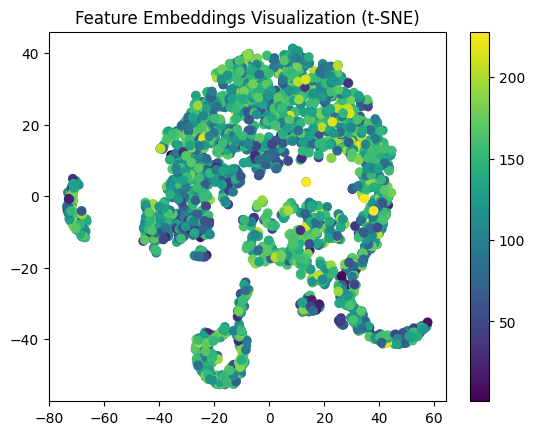

ValueError: ignored

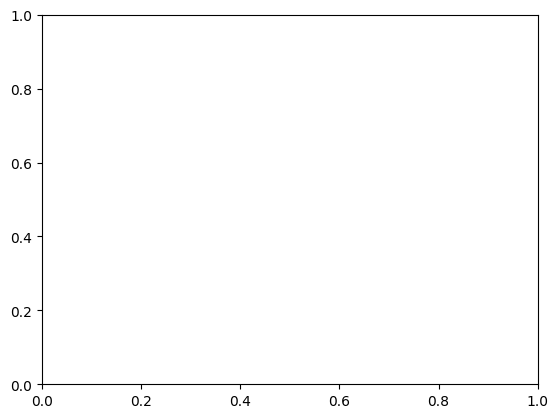

In [ ]:
# for epoch in range(1, n_epochs + 1):
#     with gpytorch.settings.use_toeplitz(False):
#         train(epoch)
#         test(20)  # Get probabilities and labels from the test set
#         #plot_calibration_curve(probabilities, labels)  # Plot the calibration curve
#     scheduler.step()
#     state_dict = model.state_dict()
#     likelihood_state_dict = likelihood.state_dict()
#     torch.save({'model': state_dict, 'likelihood': likelihood_state_dict}, 'dkl_cifar_checkpoint.dat')

for epoch in range(1, n_epochs + 1):
    with gpytorch.settings.use_toeplitz(False):
        train(epoch)
        test(20)
    scheduler.step()
    state_dict = model.state_dict()
    likelihood_state_dict = likelihood.state_dict()
    torch.save({'model': state_dict, 'likelihood': likelihood_state_dict}, 'dkl_cifar_checkpoint.dat')

# # Call the visualize_predictive_variance function after training
# visualize_predictive_variance()
